<a href="https://colab.research.google.com/github/lucabem/CompeticionMineria/blob/main/ultimo_modelo_0963.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [2]:
!rm -rf /root/.keras/datasets/*

In [3]:
dataset_url = 'https://github.com/lucabem/CompeticionMineria/blob/main/data/dataset_images.zip?raw=true'
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='train_data', 
                                   extract=True)

78069760/78067648 [==============================] - 1s 0us/step


In [4]:
!rm -rf /root/.keras/datasets/train_data.tar.gz /root/.keras/datasets/train_data
!ls -l /root/.keras/datasets/

total 24
drwxr-xr-x 27 root root  4096 Mar 21 17:48 ImagesTrain
drwxr-xr-x  2 root root 20480 Mar 21 17:48 Test


In [5]:
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')
image_count = len(list(train_path.glob('*/*.jpg')))
print(image_count)

2500


In [6]:
test_path = pathlib.Path('/root/.keras/datasets/Test')
images_test = os.listdir(test_path)
print(len(images_test))

500


In [7]:
for direct in train_path.iterdir():
  if direct.is_dir():
    direct.rename(train_path / direct.name.split(sep='_100')[0])

In [8]:
batch_size = 32
img_height = 224
img_width  = 224

In [9]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 6.8MB/s 


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
import tensorflow_addons as tfa

In [12]:
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet  
from keras.models import Sequential, Model, load_model  
from keras.layers import Conv2D, MaxPooling2D  
from keras.layers import Activation, Dropout, Flatten, Dense  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from keras import regularizers  
from keras import backend as K  
import tensorflow as tf
keras = tf.keras

### Data Augmentation

In [13]:
batch_size  = 32
img_height = 224
img_width  = 224
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')

In [14]:
import shutil
import os 

In [15]:
train_ds_gen = ImageDataGenerator(vertical_flip    = True,
                                  horizontal_flip  = True,
                                  validation_split = 0.2)

In [16]:
train_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='training',
                                                  class_mode='categorical')

Found 2000 images belonging to 25 classes.


In [17]:
valid_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='validation',
                                                  class_mode='categorical')

Found 500 images belonging to 25 classes.


In [18]:
test_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  class_mode='categorical')

Found 2500 images belonging to 25 classes.


### Modelos

#### Funcion para predecir

In [19]:
batch_size = 32
img_height = 224
img_width  = 224
test_path  = pathlib.Path('/root/.keras/datasets/Test')

In [20]:
# predicting images
from keras.preprocessing import image
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt

def make_predictions(model_final,
                     path_test ='/root/.keras/datasets/Test',
                     name_file_submission = 'submission.csv'):

  images_test = os.listdir(path_test)
  samples_to_predict = []

  for img in images_test:
    path_img = os.path.join(path_test, img)
    img = image.load_img(path_img,
                        target_size=(img_width, img_height))
    x = image.img_to_array(img)
    samples_to_predict.append(x)

  samples_to_predict  = np.array(samples_to_predict)
  predictions = model_final.predict(samples_to_predict)
  classes = np.argmax(predictions, axis = 1)

  data = {'id.jpg': images_test, 'label': classes}
  data = pd.DataFrame(data)
  data.to_csv(name_file_submission, index = False)

  return data

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
from keras.models import load_model
model_cargado = load_model('/content/drive/MyDrive/resnet50_ms_transfer_final.58-0.968.hdf5')

In [23]:
for layer in model_cargado.layers:
   layer.trainable = True


for layer in model_cargado.get_layer('resnet50').layers[0:150]:
   layer.trainable = False

model_cargado.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 1024)        18875392  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 512)         4719104   
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              9439232   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)              

In [24]:
checkpointer = ModelCheckpoint("/content/drive/MyDrive/Modelos_2/resnet50" +
                               "_ms_transfer_final." +
                               "{epoch:02d}-{val_f1_score:.3f}" +
                               ".hdf5",
                               monitor='val_f1_score',
                               verbose=1,
                               save_best_only=True,
                               mode='max')

earlystopper = EarlyStopping(monitor='val_f1_score',
                             patience=10,
                             mode='max')

In [26]:
model_history = model_cargado.fit(  
    train_data_gen,
    epochs=20,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size,
    callbacks = [checkpointer, earlystopper])

Epoch 1/20
63/63 [==============================] - 1758s 28s/step - loss: 0.1035 - accuracy: 0.9630 - f1_score: 0.9630 - val_loss: 0.3160 - val_accuracy: 0.9250 - val_f1_score: 0.9243

Epoch 00001: val_f1_score improved from -inf to 0.92425, saving model to /content/drive/MyDrive/Modelos_2/resnet50_ms_transfer_final.01-0.924.hdf5
Epoch 2/20
63/63 [==============================] - 1743s 28s/step - loss: 0.0993 - accuracy: 0.9600 - f1_score: 0.9600 - val_loss: 0.3329 - val_accuracy: 0.9375 - val_f1_score: 0.9358

Epoch 00002: val_f1_score improved from 0.92425 to 0.93580, saving model to /content/drive/MyDrive/Modelos_2/resnet50_ms_transfer_final.02-0.936.hdf5
Epoch 3/20
63/63 [==============================] - 1744s 28s/step - loss: 0.0743 - accuracy: 0.9785 - f1_score: 0.9785 - val_loss: 0.4839 - val_accuracy: 0.8938 - val_f1_score: 0.8951

Epoch 00003: val_f1_score did not improve from 0.93580
Epoch 4/20
63/63 [==============================] - 1743s 28s/step - loss: 0.0752 - accura

KeyboardInterrupt: ignored

In [28]:
model_cargado = load_model('/content/drive/MyDrive/Modelos_2/resnet50_ms_transfer_final.05-0.946.hdf5')

In [29]:
make_predictions(model_cargado, name_file_submission = 'resnet50_ms_transfer_final-05-0.946.csv' )

,id.jpg,label
0,Forest_CDN_11.jpg,6
1,Marshland__9.jpg,19
2,Forest_DDB_5.jpg,7
3,Forest_DEN_7.jpg,12
4,Forest_ODN_11.jpg,14
...,...,...
495,Cereal_Cro_5.jpg,1
496,Swamp_add__2.jpg,23
497,Moss_and_L_14.jpg,20
498,Moss_and_L_18.jpg,20


In [ ]:
train_data_gen.labels

In [30]:
from google.colab import files

files.download("resnet50_ms_transfer_final-05-0.946.csv")

model_cargado.save('model_fine')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
! zip -r model_fine.zip model_fine
files.download("model_fine.zip")

updating: model_fine/ (stored 0%)
updating: model_fine/variables/ (stored 0%)
updating: model_fine/variables/variables.index (deflated 82%)
updating: model_fine/variables/variables.data-00000-of-00001 (deflated 14%)
updating: model_fine/assets/ (stored 0%)
updating: model_fine/saved_model.pb (deflated 93%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Modelo Base

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False



global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')


model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history = model.fit(  
    train_data_gen,
    epochs=39,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/39
63/63 [==============================] - 375s 6s/step - loss: 3.5592 - f1_score: 0.0479 - val_loss: 2.7924 - val_f1_score: 0.1448
Epoch 2/39
63/63 [==============================] - 370s 6s/step - loss: 2.6699 - f1_score: 0.1932 - val_loss: 2.3542 - val_f1_score: 0.3507
Epoch 3/39
63/63 [==============================] - 368s 6s/step - loss: 2.2493 - f1_score: 0.4133 - val_loss: 2.0852 - val_f1_score: 0.4473
Epoch 4/39
63/63 [==============================] - 368s 6s/step - loss: 2.0113 - f1_score: 0.5008 - val_loss: 1.8877 - val_f1_score: 0.5239
Epoch 5/39
63/63 [==============================] - 367s 6s/step - loss: 1.8279 - f1_score: 0.5581 - val_loss: 1.7658 - val_f1_score: 0.5616
Epoch 6/39
63/63 [==============================] - 367s 6s/step - loss: 1.6742 - f1_score: 0.6330 - val_loss: 1.6522 - val_f1_score: 0.6148
Epoch 7/39
63/63 [==============================] - 366s 6s/step - loss: 1.5781 - f1_score: 0.6815 - val_loss: 1.5685 - val_f1_score: 0.6581
Epoch 8/39
63

In [ ]:
model.save('model_base')

INFO:tensorflow:Assets written to: model_base/assets


In [ ]:
make_predictions(model,  name_file_submission='model_base.csv')

,id.jpg,label
0,Cereal_Cro_17.jpg,12
1,Forest_DEB_6.jpg,11
2,Forest_ODN_9.jpg,14
3,Moss_and_L_16.jpg,20
4,Forest_DDB_3.jpg,1
...,...,...
495,Close_Shru_11.jpg,2
496,Marshland__18.jpg,19
497,Forest_DEB_8.jpg,11
498,Forest_DEN_9.jpg,12


In [ ]:
from google.colab import files
files.download("model_base.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Modelo Mejorado

##### Modelo 1

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512, activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

dropout          = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_1 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  prediction_layer
])


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_1.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history_1 = model_1.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/50
63/63 [==============================] - 383s 6s/step - loss: 3.1334 - f1_score: 0.1046 - val_loss: 2.5181 - val_f1_score: 0.4795
Epoch 2/50
63/63 [==============================] - 378s 6s/step - loss: 2.5349 - f1_score: 0.3676 - val_loss: 1.9645 - val_f1_score: 0.6243
Epoch 3/50
63/63 [==============================] - 390s 6s/step - loss: 2.0416 - f1_score: 0.5068 - val_loss: 1.5346 - val_f1_score: 0.7232
Epoch 4/50
63/63 [==============================] - 389s 6s/step - loss: 1.6152 - f1_score: 0.6252 - val_loss: 1.2329 - val_f1_score: 0.7495
Epoch 5/50
63/63 [==============================] - 388s 6s/step - loss: 1.3752 - f1_score: 0.6677 - val_loss: 1.0576 - val_f1_score: 0.7800
Epoch 6/50
63/63 [==============================] - 390s 6s/step - loss: 1.1837 - f1_score: 0.7032 - val_loss: 0.9077 - val_f1_score: 0.7835
Epoch 7/50
63/63 [==============================] - 386s 6s/step - loss: 1.0406 - f1_score: 0.7454 - val_loss: 0.8434 - val_f1_score: 0.7952
Epoch 8/50
63

In [ ]:
model_1.save('model_2048_512_1024')

INFO:tensorflow:Assets written to: model_2048_512_1024/assets


In [ ]:
make_predictions(model_1, name_file_submission='modelo_mejorado_2048_512_1024.csv')

,id.jpg,label
0,Cereal_Cro_17.jpg,17
1,Forest_DEB_6.jpg,11
2,Forest_ODN_9.jpg,14
3,Moss_and_L_16.jpg,20
4,Forest_DDB_3.jpg,9
...,...,...
495,Close_Shru_11.jpg,2
496,Marshland__18.jpg,19
497,Forest_DEB_8.jpg,11
498,Forest_DEN_9.jpg,12


In [ ]:

files.download("modelo_mejorado_2048_512_1024.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
! zip -r modelo_mejorado_2048_512_1024.zip model_2048_512_1024

  adding: model_2048_512_1024/ (stored 0%)
  adding: model_2048_512_1024/variables/ (stored 0%)
  adding: model_2048_512_1024/variables/variables.index (deflated 78%)
  adding: model_2048_512_1024/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: model_2048_512_1024/assets/ (stored 0%)
  adding: model_2048_512_1024/saved_model.pb (deflated 93%)


In [ ]:
files.download("modelo_mejorado_2048_512_1024.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

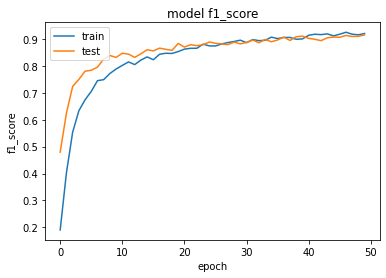

In [ ]:
plt.plot(model_history_1.history['f1_score'])
plt.plot(model_history_1.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Modelo 2

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512,  activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

conv_1024 = Conv2D(1024, (3,3), activation='relu')
conv_512  = Conv2D(512, (3,3), activation='relu')

flattern  = Flatten()
batch_normal = BatchNormalization()
dropout   = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_2 = tf.keras.Sequential([
  base_model,
  conv_1024,
  conv_512,
  flattern,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  prediction_layer
])

In [ ]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_2.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[ 'accuracy', tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history_2 = model_2.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/50
63/63 [==============================] - 534s 8s/step - loss: 2.9284 - accuracy: 0.1840 - f1_score: 0.1570 - val_loss: 1.7577 - val_accuracy: 0.5104 - val_f1_score: 0.4624
Epoch 2/50
63/63 [==============================] - 522s 8s/step - loss: 1.6498 - accuracy: 0.5271 - f1_score: 0.5170 - val_loss: 1.0158 - val_accuracy: 0.6979 - val_f1_score: 0.6819
Epoch 3/50
63/63 [==============================] - 520s 8s/step - loss: 1.0721 - accuracy: 0.6886 - f1_score: 0.6852 - val_loss: 0.7204 - val_accuracy: 0.7896 - val_f1_score: 0.7903
Epoch 4/50
63/63 [==============================] - 518s 8s/step - loss: 0.7728 - accuracy: 0.7669 - f1_score: 0.7673 - val_loss: 0.6525 - val_accuracy: 0.8021 - val_f1_score: 0.8001
Epoch 5/50
63/63 [==============================] - 517s 8s/step - loss: 0.6814 - accuracy: 0.7969 - f1_score: 0.7958 - val_loss: 0.5773 - val_accuracy: 0.8146 - val_f1_score: 0.8170
Epoch 6/50
63/63 [==============================] - 517s 8s/step - loss: 0.5503 - acc

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

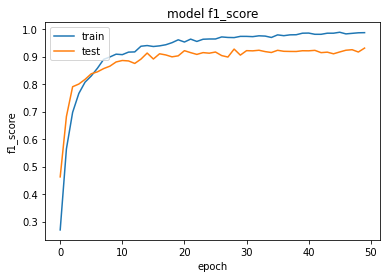

In [ ]:
plt.plot(model_history_2.history['f1_score'])
plt.plot(model_history_2.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
make_predictions(model_2, name_file_submission='modelo_mejorado_2048_512_1024_256_128_52.csv')

,id.jpg,label
0,Cereal_Cro_17.jpg,7
1,Forest_DEB_6.jpg,11
2,Forest_ODN_9.jpg,14
3,Moss_and_L_16.jpg,20
4,Forest_DDB_3.jpg,9
...,...,...
495,Close_Shru_11.jpg,2
496,Marshland__18.jpg,19
497,Forest_DEB_8.jpg,11
498,Forest_DEN_9.jpg,12


In [ ]:
files.download("modelo_mejorado_2048_512_1024_256_128_52.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_2.save('modelo_mejorado_2048_512_1024_256_128_52')

INFO:tensorflow:Assets written to: modelo_mejorado_2048_512_1024_256_128_52/assets


In [ ]:
! zip -r modelo_mejorado_2048_512_1024_256_128_52.zip modelo_mejorado_2048_512_1024_256_128_52

  adding: modelo_mejorado_2048_512_1024_256_128_52/ (stored 0%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/variables/ (stored 0%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/variables/variables.index (deflated 78%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/assets/ (stored 0%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/saved_model.pb (deflated 93%)


In [ ]:
files.download("modelo_mejorado_2048_512_1024_256_128_52.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Modelo 3

In [ ]:
from keras.layers.normalization import BatchNormalization

In [ ]:
base_model = tf.keras.applications.DenseNet201(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

model_3 = Sequential()
model_3.add(Conv2D(64,
                 kernel_size=(3, 3), 
                 activation='relu', 
                 input_shape=(224, 224, 3)))
model_3.add(BatchNormalization())

model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(BatchNormalization())

model_3.add(Conv2D(128,
                 kernel_size=(3, 3), 
                 activation='relu'))
model_3.add(BatchNormalization())

model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(BatchNormalization())

model_3.add(Flatten())

dense_layer_1024_1 = Dense(1024, activation='relu')
dense_layer_1024_2 = Dense(1024, activation='relu')

model_3.add(dense_layer_1024_1)
model_3.add(Dropout(0.25))
model_3.add(dense_layer_1024_2)

prediction_layer = keras.layers.Dense(25, activation='softmax')

model_3.add(prediction_layer)

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
opt = tf.keras.optimizers.Adagrad()

model_3.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[ 'categorical_accuracy',
                      tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
checkpointer = ModelCheckpoint("modelo_3/densenet" +
                               "_ms_transfer_final." +
                               "{epoch:02d}-{val_categorical_accuracy:.3f}" +
                               ".hdf5",
                               monitor='val_categorical_accuracy',
                               verbose=1,
                               save_best_only=True,
                               mode='max')

earlystopper = EarlyStopping(monitor='val_categorical_accuracy',
                             patience=10,
                             mode='max')


In [ ]:
tf.random.set_seed(2021)

model_history_3 = model_3.fit(  
    train_data_gen,
    epochs=100,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size,
    callbacks=[checkpointer, earlystopper])

Epoch 1/100
63/63 [==============================] - 761s 12s/step - loss: 2.6319 - categorical_accuracy: 0.3250 - f1_score: 0.3169 - val_loss: 7.5042 - val_categorical_accuracy: 0.0750 - val_f1_score: 0.0490

Epoch 00001: val_categorical_accuracy improved from -inf to 0.07500, saving model to modelo_3/densenet_ms_transfer_final.01-0.075.hdf5
Epoch 2/100
63/63 [==============================] - 767s 12s/step - loss: 1.4769 - categorical_accuracy: 0.5777 - f1_score: 0.5731 - val_loss: 3.4708 - val_categorical_accuracy: 0.2625 - val_f1_score: 0.1869

Epoch 00002: val_categorical_accuracy improved from 0.07500 to 0.26250, saving model to modelo_3/densenet_ms_transfer_final.02-0.262.hdf5
Epoch 3/100
63/63 [==============================] - 770s 12s/step - loss: 1.1448 - categorical_accuracy: 0.6416 - f1_score: 0.6407 - val_loss: 1.8489 - val_categorical_accuracy: 0.4458 - val_f1_score: 0.4121

Epoch 00003: val_categorical_accuracy improved from 0.26250 to 0.44583, saving model to modelo_3/

#### Fine Tunning

In [ ]:
opt = tf.keras.optimizers.Adagrad()

model_3.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[ 'categorical_crossentropy', tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
checkpointer = ModelCheckpoint("resnet50" +
                               "_ms_transfer_final." +
                               "{epoch:02d}-{val_categorical_accuracy:.3f}" +
                               ".hdf5",
                               monitor='val_categorical_accuracy',
                               verbose=1,
                               save_best_only=True,
                               mode='max')

earlystopper = EarlyStopping(monitor='val_categorical_accuracy',
                             patience=10,
                             mode='max')


#### Predicciones

In [ ]:
make_predictions(model,  name_file_submission='model_2048_512_1024.csv')